For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: 

https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.invariant/197901/catalog.html?dataset=files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

*Skill check in:* due Friday, Mar 1, end of day to slack: Plot maps of the mean SST and mean total column water vapor for the entire period of record.

In [1]:
# import needed packages

import xarray as xr
import pandas as pd 
import numpy as np 
import datetime as datetime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller




In [2]:
# import dask and start client

import dask
from dask.distributed import Client, progress
dask.config.set(temporary_directory='/tmp/snesbitt/dask-worker/')

In [3]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 19.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50720,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 19.86 GiB
Comm: tcp://127.0.0.1:50742,Total threads: 4
Dashboard: http://127.0.0.1:50744/status,Memory: 4.96 GiB
Nanny: tcp://127.0.0.1:50723,


In [4]:
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

In [5]:
# check ds
ds

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] dask.array<chunksize=(516,), meta=np.ndarray>
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [6]:
# get it in netcdf format
#ds.to_netcdf('raw_data.nc')


In [7]:
raw_ds = xr.open_dataset('raw_data.nc')
raw_ds

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [8]:
# Open the land-sea mask dataset
ds_lsm = xr.open_dataset(
    'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
    engine='netcdf4'
)


In [9]:
# the dataset opens perfectly
ds_lsm

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    utc_date   (time) int32 ...
    LSM        (time, latitude, longitude) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper04 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon May 13 18:10:35 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon May 13 18:10:35 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.4 (http://n...
    DODS_EXTRA.Unlimited_Dimension:  time

I ended up using someone elses suggestion on slack in reference to using the SST dataset as a mask, since my LSM mask was not working at all.

In [10]:
# define the Pacific Basin
#lat_min, lat_max = -65, 65
#lon_min, lon_max = 120, 300  # 60°W = 300°E

# select the land-sea mask data for the Pacific Basin
lsm_pacific_basin = ds_lsm.sel(latitude=slice(65, -65, 4), longitude=slice(120, 300, 4))

lsm_pacific_basin


<xarray.Dataset>
Dimensions:    (latitude: 131, longitude: 181, time: 1)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    utc_date   (time) int32 ...
    LSM        (time, latitude, longitude) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper04 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon May 13 18:10:35 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon May 13 18:10:35 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.4 (http://n...
    DODS_EXTRA.Unlimited_Dimension:  time

In [11]:
# Rename coords to lat and lon to match the initial dataset
lsm_pb_mask = lsm_pacific_basin.rename({'latitude':'lat','longitude':'lon'})

#lsm_pb_mask
lsm_filter = (lsm_pb_mask.LSM == 0).squeeze(['time'], drop=True)

lsm_filter
# Find where only water is on the map
#sea_only_lsm=total_water_mean.where(mask
#filtered_ds = raw_ds.where(lsm_filter, drop=True)

# Apply the land-sea mask to your dataset by multiplication



<xarray.DataArray 'LSM' (lat: 131, lon: 181)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 65.0 64.0 63.0 62.0 61.0 ... -62.0 -63.0 -64.0 -65.0
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0

In [12]:
# Collapse the time dimension of the land-sea mask dataset, it does not contribute much either way
# since it has one time stamp
#lsm_pacific = lsm_pacific_basin.mean(dim='time')

# Apply land sea mask to sst ds
#sst_ds_mask = sst_ds.where(lsm_pacific == 1)
#sst_ds_mask

# Apply land sea mask to tcwv ds
#tcwv_ds_mask = tcwv_ds.where(lsm_pacific == 1)
#tcwv_ds_mask

# I did use chatgpt to help with applying the mask! 
# helpful explanation:
# condition lsm_pacific == 1, we're specifying that we want to keep the values from the original dataset where the land-sea mask equals 1 (sea areas) 
# and replace values where the mask equals 0 (land areas) with NaNs.
# In most land-sea mask datasets, the convention is to use 1 to represent sea areas and 0 to represent land areas.

So, I left this above section of code in however please disregard it

SKILL CHECK-IN

In [13]:
# collapse time dim to make it 2D for plotting
sst_avg = raw_ds['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim='time')

# Create a mask using the SST data
mask = xr.where(np.isnan(sst_avg), False, True)

# Apply the mask to the data variable you want to filter (e.g., Total_column_water_vapour_surface_Mixed_intervals_Average)
tcwv_masked = raw_ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].where(mask)

tcwv_masked
# subtract the climatology from each data point to obtain anomalies
sst_anomalies = raw_ds['Sea_surface_temperature_surface_Mixed_intervals_Average'] - sst_avg
sst_anomalies

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[           nan,            nan,            nan, ...,
         -1.1649475e+00, -1.2564697e+00, -1.3612671e+00],
        [           nan,            nan,            nan, ...,
         -1.3996887e+00, -1.5570679e+00, -1.4213257e+00],
        [           nan,            nan,            nan, ...,
         -1.6243591e+00, -1.5296936e+00, -1.2372437e+00],
        ...,
        [ 1.8227844e+00,  1.7001343e+00,  1.6875916e+00, ...,
          1.1339722e+00,  1.2215881e+00,  1.3164673e+00],
        [ 1.2904663e+00,  1.2356567e+00,  1.1486511e+00, ...,
          1.0923767e+00,  1.3601379e+00,  1.5830383e+00],
        [ 9.3377686e-01,  9.1293335e-01,  8.3343506e-01, ...,
         -8.6364746e-03, -2.9357910e-01,            nan]],

       [[           nan,            nan,            nan, ...,
         -1.1649475e+00, -1.2564697e+00, -1.3622437e+00],
        [           nan,            nan,            nan, ...,
         -1.3996887e+00, -1.5775757e+00, -1.6752319e+00],
        [           nan,            nan,            nan, ...,
         -1.6643982e+00, -1.5912170e+00, -1.5243530e+00],
...
        [-5.2169800e-01, -5.1153564e-01, -5.4849243e-01, ...,
         -1.1968994e-01,  2.0816040e-01,  3.9971924e-01],
        [-7.9425049e-01, -6.6644287e-01, -5.1712036e-01, ...,
          2.6254272e-01,  3.4085083e-01,  4.0164185e-01],
        [-6.5484619e-01, -6.9131470e-01, -7.0538330e-01, ...,
          8.6563110e-01,  2.5158691e-01,            nan]],

       [[           nan,            nan,            nan, ...,
         -1.0445862e+00, -1.1165771e+00, -1.1920776e+00],
        [           nan,            nan,            nan, ...,
         -1.2344055e+00, -1.3204956e+00, -1.0314331e+00],
        [           nan,            nan,            nan, ...,
         -1.3955994e+00, -9.7769165e-01, -2.9168701e-01],
        ...,
        [ 1.8826294e-01,  2.1014404e-01,  1.8099976e-01, ...,
          6.3909912e-01,  8.9859009e-01,  1.0325317e+00],
        [ 3.1414795e-01,  2.9449463e-01,  3.5202026e-01, ...,
          9.0609741e-01,  9.2385864e-01,  7.8445435e-01],
        [-7.3852539e-03,  9.4818115e-02,  2.2235107e-01, ...,
          1.6498108e+00,  1.0689697e+00,            nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...

In [14]:
# convert kelvin to celcius
sst_anomalies_c = sst_anomalies - 273.15
#sst_anomalies_c
sst_ano_c = sst_anomalies_c.mean(dim='time')
sst_ano_c


<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)>
array([[       nan,        nan,        nan, ..., -273.1493 , -273.14996,
        -273.1504 ],
       [       nan,        nan,        nan, ..., -273.14954, -273.15048,
        -273.15033],
       [       nan,        nan,        nan, ..., -273.15015, -273.15002,
        -273.15005],
       ...,
       [-273.15015, -273.15012, -273.15012, ..., -273.1499 , -273.14987,
        -273.1501 ],
       [-273.1499 , -273.15002, -273.1501 , ..., -273.1498 , -273.14987,
        -273.15002],
       [-273.15005, -273.15057, -273.1503 , ..., -273.14984, -273.15002,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0

In [15]:
# convert kelvin to celcius
sst_avg_c = sst_avg - 273.15
sst_avg_c

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)>
array([[        nan,         nan,         nan, ..., -0.5248413 ,
        -0.4333191 , -0.32754517],
       [        nan,         nan,         nan, ..., -0.2901001 ,
        -0.10928345,  0.41610718],
       [        nan,         nan,         nan, ...,  0.02636719,
         0.6934204 ,  1.5308533 ],
       ...,
       [-0.42175293, -0.42214966, -0.3949585 , ..., -0.16067505,
        -0.15649414, -0.3138733 ],
       [-0.67263794, -0.627594  , -0.6079712 , ..., -0.49212646,
        -0.39074707, -0.9202881 ],
       [-1.0346985 , -0.99823   , -0.9841614 , ..., -1.0112305 ,
        -1.4147644 ,         nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0

In [16]:
#tcwv_avg = raw_ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim='time')

tcwv_avg = tcwv_masked.mean(dim='time')
tcwv_avg

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               lat: 130,
                                                                               lon: 181)>
array([[      nan,       nan,       nan, ..., 7.2652626, 7.301556 ,
        7.3453784],
       [      nan,       nan,       nan, ..., 7.540066 , 7.58028  ,
        7.6451983],
       [      nan,       nan,       nan, ..., 7.831519 , 7.8995957,
        7.982397 ],
       ...,
       [6.6010046, 6.642698 , 6.687775 , ..., 7.800156 , 7.7307844,
        7.6080174],
       [6.1961045, 6.2419133, 6.2850037, ..., 7.343944 , 7.350072 ,
        7.1706514],
       [5.7423973, 5.7851033, 5.8230634, ..., 6.843616 , 5.137864 ,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0

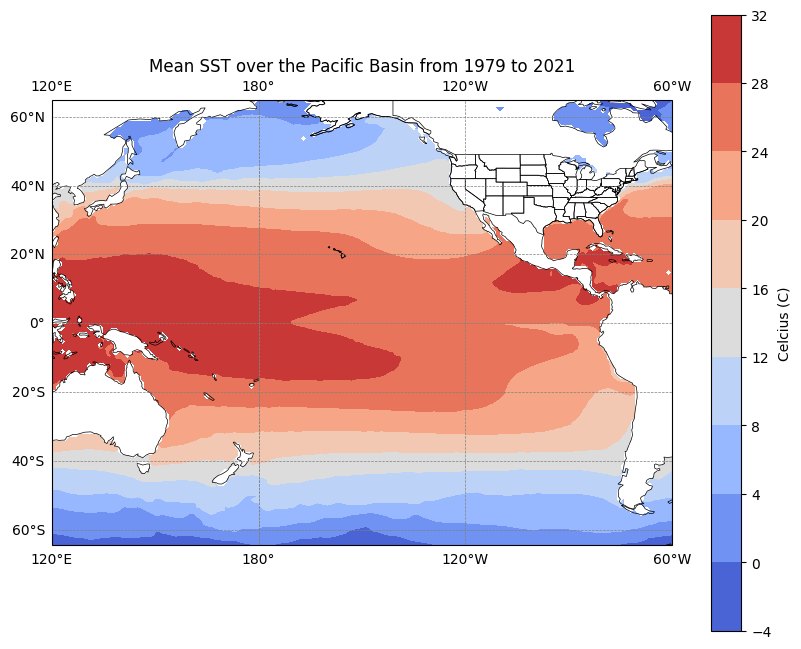

In [17]:
import matplotlib.cm as cmap 

# establish lat and lon values for future use
lat = sst_avg_c['lat']
lon = sst_avg_c['lon']

# Create meshgrid
X, Y = np.meshgrid(lon, lat)

# Create figure and projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot everything! 
p1 = ax.contourf(X, Y, sst_avg_c, cmap='coolwarm', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# Add titles, labels, ect
plt.title("Mean SST over the Pacific Basin from 1979 to 2021")
plt.colorbar(p1, label="Celcius (C)")
plt.show()


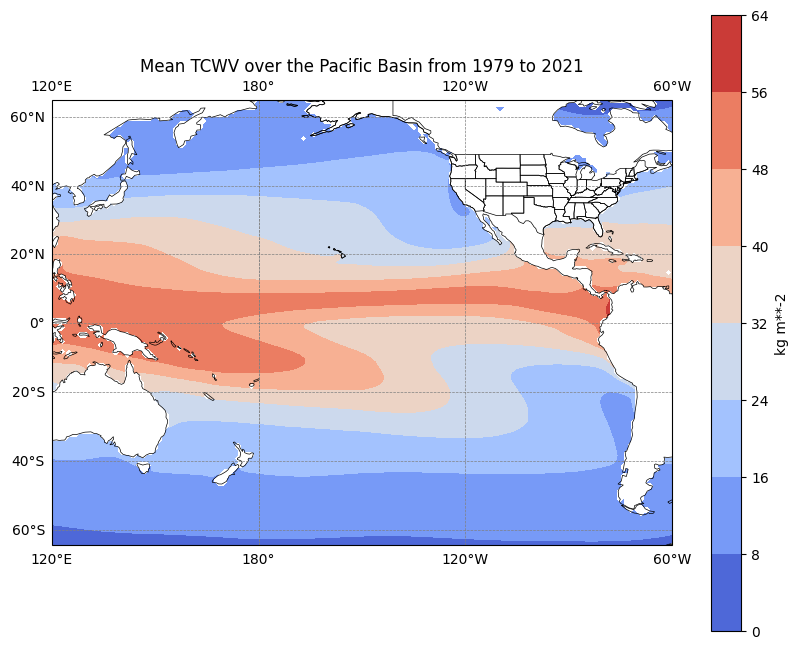

In [18]:
# establish lat and lon values for future use
lat2 = tcwv_avg['lat']
lon2 = tcwv_avg['lon']

# Create meshgrid
X2, Y2 = np.meshgrid(lon2, lat2)

# Create figure and projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot everything! 
p2 = ax.contourf(X2, Y2, tcwv_avg, cmap='coolwarm', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# Add titles, labels, ect
plt.title("Mean TCWV over the Pacific Basin from 1979 to 2021")
plt.colorbar(p2, label="kg m**-2")
plt.show()


END SKILL CHECK-IN

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)
   
   Hints: [Monthly data analysis &#8212; PyCLIM_101 0.2 documentation](https://climate.usu.edu/people/yoshi/pyclm101/monthly.html)

In [19]:
# create a new SST dataset to use for the remaining hw problems
sst = raw_ds['Sea_surface_temperature_surface_Mixed_intervals_Average']
sst

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[      nan,       nan, ..., 271.4602 , 271.46118],
        [      nan,       nan, ..., 271.48364, 272.14478],
        ...,
        [273.76782, 273.75806, ..., 274.1194 , 273.81274],
        [273.04907, 273.0647 , ..., 271.44165,       nan]],

       [[      nan,       nan, ..., 271.4602 , 271.4602 ],
        [      nan,       nan, ..., 271.46313, 271.89087],
        ...,
        [273.49536, 273.50806, ..., 273.927  , 273.71802],
        [272.51587, 272.54907, ..., 271.73657,       nan]],

       ...,

       [[      nan,       nan, ..., 272.99854, 273.05615],
        [      nan,       nan, ..., 273.2378 , 274.1714 ],
        ...,
        [271.6831 , 271.85596, ..., 273.1001 , 272.63135],
        [271.46045, 271.46045, ..., 271.98682,       nan]],

       [[      nan,       nan, ..., 271.6001 , 271.63037],
        [      nan,       nan, ..., 271.7202 , 272.53467],
        ...,
        [272.7915 , 272.8169 , ..., 273.6831 , 273.01416],
        [272.1079 , 272.24658, ..., 272.8042 ,       nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [20]:
# reference your tcwv dataset again for a reminder! all coords and the shape looks correct
tcwv_masked

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
array([[[       nan,        nan,        nan, ...,  3.9752629,
          4.121747 ,  4.288739 ],
        [       nan,        nan,        nan, ...,  4.0983095,
          4.2789736,  4.494794 ],
        [       nan,        nan,        nan, ...,  4.322919 ,
          4.5358095,  4.7653017],
        ...,
        [ 7.7789736,  7.804364 ,  7.784833 , ..., 10.812177 ,
         10.616864 , 10.352216 ],
        [ 7.361005 ,  7.4069033,  7.4733095, ...,  9.966474 ,
          9.878583 ,  9.584638 ],
        [ 7.055341 ,  7.09538  ,  7.1520205, ...,  9.430341 ,
          7.1070986,        nan]],

       [[       nan,        nan,        nan, ...,  3.153113 ,
          3.3884645,  3.6101441],
        [       nan,        nan,        nan, ...,  3.4333863,
          3.7517457,  4.1267457],
        [       nan,        nan,        nan, ...,  3.8679566,
          4.3054566,  4.7097535],
...
        [ 5.3542223,  5.3981676,  5.457738 , ...,  8.306371 ,
          8.258519 ,  8.167699 ],
        [ 4.987035 ,  5.027074 ,  5.067113 , ...,  8.026097 ,
          8.069066 ,  7.8649645],
        [ 4.5973864,  4.6325426,  4.7018785, ...,  7.5925035,
          5.5768785,        nan]],

       [[       nan,        nan,        nan, ...,  4.5242953,
          4.685428 ,  4.9364047],
        [       nan,        nan,        nan, ...,  4.601444 ,
          4.804569 ,  5.0662875],
        [       nan,        nan,        nan, ...,  4.7362094,
          4.9832797,  5.232303 ],
        ...,
        [ 8.625857 ,  8.701053 ,  8.73035  , ...,  9.149295 ,
          9.100467 ,  8.997928 ],
        [ 8.394412 ,  8.287967 ,  8.1366   , ...,  8.719607 ,
          8.747928 ,  8.56824  ],
        [ 7.4588656,  7.3162875,  7.1532016, ...,  8.381717 ,
          6.3280063,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/14)
    long_name:                       Total column water vapour (Mixed_interva...
    units:                           kg m**-2
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-137_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 137
    Grib1_Parameter_Name:            tcwv
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [21]:
from scipy import signal

# Handling infinite values by replacing them with NaN
sst_2 = sst.where(np.isfinite(sst), np.nan)

# Calculating climatology (monthly means) and anomalies, skipping NaN values
climatology = sst_2.groupby('time.month').mean('time', skipna=True)
anomalies = sst_2.groupby('time.month') - climatology

# Detrending the anomalies
def detrend(da):
    da_no_nan = da.fillna(0)
    detrended = xr.apply_ufunc(signal.detrend, da_no_nan, kwargs={'axis': 0}, dask='allowed')
    return detrended.where(~da.isnull())
detrended_anomalies = detrend(anomalies)

detrended_anomalies # I think it worked? maybe? I did use a classmates code from the chat that perfectly worked
# with my code, very helpful and informative

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[        nan,         nan,         nan, ...,  0.3785534 ,
          0.32773766,  0.27953318],
        [        nan,         nan,         nan, ...,  0.33988896,
          0.33014104,  0.8658454 ],
        [        nan,         nan,         nan, ...,  0.37187833,
          0.9608817 ,  1.690913  ],
        ...,
        [ 0.12344213, -0.09005523, -0.09553048, ..., -0.40914473,
         -0.2977621 , -0.05632283],
        [-0.26822397, -0.32354596, -0.39419833, ..., -0.03340179,
          0.0589895 ,  0.6083368 ],
        [-0.3430309 , -0.35550085, -0.42600065, ..., -0.27579945,
         -0.65458703,         nan]],

       [[        nan,         nan,         nan, ...,  0.37726617,
          0.33196723,  0.30229712],
        [        nan,         nan,         nan, ...,  0.3429144 ,
          0.33346456,  0.7373431 ],
        [        nan,         nan,         nan, ...,  0.3474856 ,
          1.0256822 ,  1.7274754 ],
...
        [ 0.29578042,  0.34558946,  0.29208443, ...,  0.40119684,
          0.68057483,  0.6904073 ],
        [-0.06648191,  0.05997695,  0.18999138, ...,  0.46955216,
          0.42558074,  0.21833578],
        [-0.10925636, -0.13638408, -0.16721511, ...,  0.2903074 ,
          0.06725013,         nan]],

       [[        nan,         nan,         nan, ..., -0.28818136,
         -0.24213809, -0.2758982 ],
        [        nan,         nan,         nan, ..., -0.26148525,
         -0.27617717, -0.08953044],
        [        nan,         nan,         nan, ..., -0.28220338,
          0.05763832,  0.1578474 ],
        ...,
        [-0.09092305, -0.03413202, -0.06624191, ..., -0.05612723,
          0.0962661 ,  0.19290185],
        [ 0.05697872,  0.02050153,  0.04605462, ...,  0.04471642,
         -0.06688276, -0.15000018],
        [-0.08205415, -0.0554298 ,  0.021818  , ...,  0.30180275,
          0.33349395,         nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [22]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# reshape data to fit 2 dimensions, combine lat and lon into 1 dim
# time is the 1st dim, hence 0 
reshaped_detrended_ano = detrended_anomalies.values.reshape(detrended_anomalies.shape[0], -1)

scaler = StandardScaler().fit(reshaped_detrended_ano)
print("Mean values:", scaler.mean_)
print("Std values:", scaler.scale_)

Mean values: [           nan            nan            nan ... 3.52891841e-08
 8.60570937e-09            nan]
Std values: [       nan        nan        nan ... 0.45785022 0.44360283        nan]


c:\Users\Sophie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Sophie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Sophie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [23]:
# get STD of dentrended_anomalies
sst_std_ano = detrended_anomalies.std()

# standardize this variable
standardized_anomalies = detrended_anomalies / sst_std_ano
standardized_anomalies


<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[        nan,         nan,         nan, ...,  0.5935346 ,
          0.5138605 ,  0.4382806 ],
        [        nan,         nan,         nan, ...,  0.53291255,
          0.5176288 ,  1.3575606 ],
        [        nan,         nan,         nan, ...,  0.5830688 ,
          1.5065683 ,  2.6511858 ],
        ...,
        [ 0.19354516, -0.14119779, -0.14978243, ..., -0.6414988 ,
         -0.46686178, -0.08830868],
        [-0.4205489 , -0.50728834, -0.61806434, ..., -0.05237073,
          0.09248975,  0.9538125 ],
        [-0.5378388 , -0.5573905 , -0.66792727, ..., -0.4324265 ,
         -1.0263283 ,         nan]],

       [[        nan,         nan,         nan, ...,  0.5915164 ,
          0.5204921 ,  0.47397226],
        [        nan,         nan,         nan, ...,  0.5376562 ,
          0.5228397 ,  1.1560817 ],
        [        nan,         nan,         nan, ...,  0.54482335,
          1.6081692 ,  2.708512  ],
...
        [ 0.4637547 ,  0.5418504 ,  0.45795974, ...,  0.6290373 ,
          1.0670747 ,  1.0824909 ],
        [-0.10423712,  0.09403797,  0.29788786, ...,  0.7362118 ,
          0.6672689 ,  0.34232908],
        [-0.17130327, -0.21383688, -0.2621769 , ...,  0.45517355,
          0.10544161,         nan]],

       [[        nan,         nan,         nan, ..., -0.45184013,
         -0.37964877, -0.4325813 ],
        [        nan,         nan,         nan, ..., -0.40998325,
         -0.4330187 , -0.14037496],
        [        nan,         nan,         nan, ..., -0.44246724,
          0.09037123,  0.24748926],
        ...,
        [-0.14255843, -0.05351566, -0.10386082, ..., -0.08800199,
          0.15093581,  0.3024512 ],
        [ 0.08933704,  0.03214439,  0.07220913, ...,  0.07011096,
         -0.10486561, -0.2351856 ],
        [-0.12865286, -0.0869085 ,  0.03420849, ...,  0.47319713,
          0.5228858 ,         nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

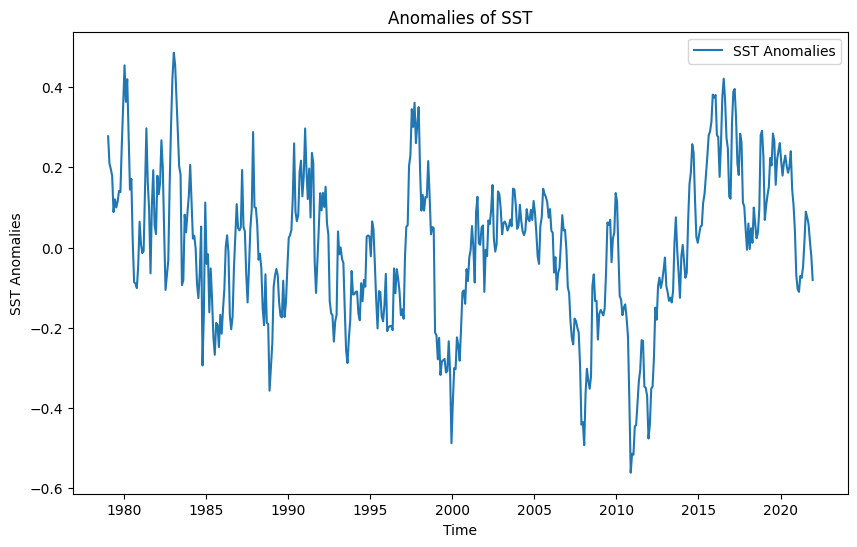

In [24]:
time_values = standardized_anomalies.coords['time'].values
std_ano_subset = standardized_anomalies.mean(dim=('lat', 'lon'))

plt.figure(figsize=(10,6))
plt.plot(time_values, std_ano_subset, label='SST Anomalies')
plt.xlabel('Time')
plt.ylabel('SST Anomalies')
plt.title('Anomalies of SST')
plt.legend()
plt.show()


In [25]:
from eofs.xarray import Eof

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(standardized_anomalies.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(standardized_anomalies, weights=wgts)

In [26]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point,
eof1 = solver.eofsAsCorrelation(neofs=5)
eof1

var_frac = solver.varianceFraction()

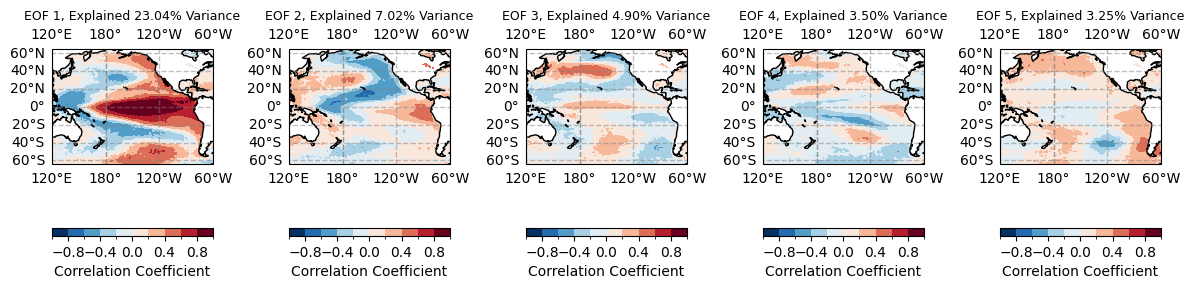

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

# Plotting the map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 13), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOFs
for i in range(5):
    clevs = np.linspace(-1, 1, 11)
    ax = axes[i]
    fill = eof1[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Calculate variance fraction
    ax.set_title(f'EOF {i+1}, Explained {var_frac[i].values*100:.2f}% Variance', fontsize=9)
    
    # add colorbar
    cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Correlation Coefficient', fontsize=10)

#plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.show()




4) Plot the percent of variance explained by the first 10 EOFs.

In [28]:
# This method in EOF analysis calculates the percentage of total variance explained
# by each EOF mode. 
varfrac = solver.varianceFraction()

(3.1240753557599816e-16, 0.2403663045167923)

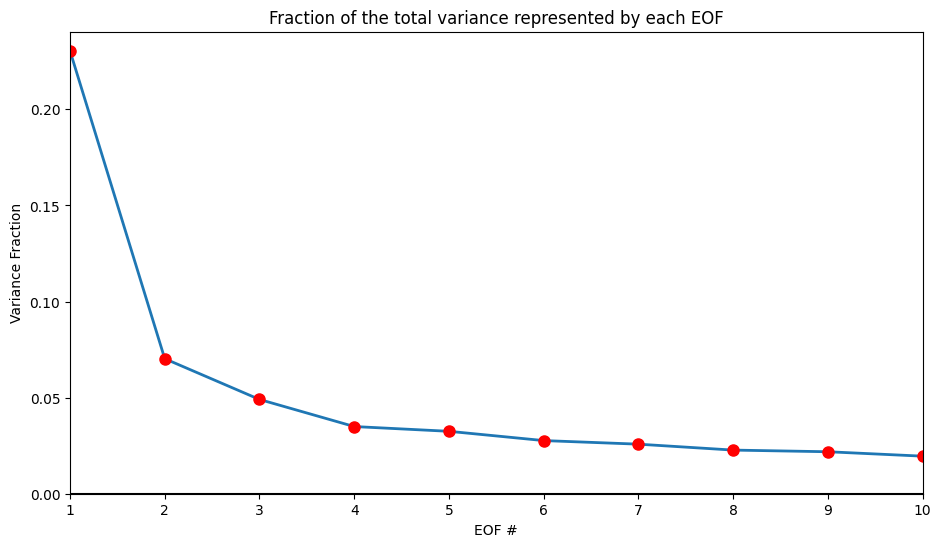

In [29]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

This is my attempt using my anomalies sst dataset

In [30]:
# here is the plot with the SST anomalies dataset; I am setting up the PC time series
# and then reconstruct the spatial field from the PC? 
pc1 = solver.pcs(npcs=5, pcscaling=1)
recon_sst = solver.reconstructedField(5)

In [31]:
recon_sst

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[        nan,         nan,         nan, ...,  0.58692354,
          0.52516574,  0.5036253 ],
        [        nan,         nan,         nan, ...,  0.55080605,
          0.53406054,  0.55875427],
        [        nan,         nan,         nan, ...,  0.44603902,
          0.60384256,  0.7632672 ],
        ...,
        [ 0.07798698,  0.07246373,  0.05980989, ...,  0.07244218,
          0.15643086,  0.20712247],
        [ 0.0231642 ,  0.02273146,  0.0061143 , ...,  0.06417508,
          0.12279523,  0.06120446],
        [-0.0120644 , -0.02606396, -0.03327308, ..., -0.16272826,
         -0.18946594,         nan]],

       [[        nan,         nan,         nan, ...,  0.7180111 ,
          0.6779013 ,  0.64671034],
        [        nan,         nan,         nan, ...,  0.65869004,
          0.6396092 ,  0.67409813],
        [        nan,         nan,         nan, ...,  0.5241746 ,
          0.71843106,  0.9256655 ],
...
        [-0.05110334, -0.06472342, -0.06767479, ...,  0.26188725,
          0.2581221 ,  0.23219341],
        [-0.12630528, -0.11255552, -0.08627602, ...,  0.20306174,
          0.18446487,  0.13004933],
        [-0.12607867, -0.11916098, -0.11182529, ...,  0.06102576,
         -0.00575574,         nan]],

       [[        nan,         nan,         nan, ...,  0.36097357,
          0.3201922 ,  0.30992284],
        [        nan,         nan,         nan, ...,  0.3522376 ,
          0.31897148,  0.3275811 ],
        [        nan,         nan,         nan, ...,  0.28748915,
          0.3210868 ,  0.2697181 ],
        ...,
        [-0.07621419, -0.08540487, -0.07193178, ...,  0.2598102 ,
          0.26299632,  0.24002002],
        [-0.1591659 , -0.12806334, -0.10702813, ...,  0.17272136,
          0.17623864,  0.12325364],
        [-0.13706042, -0.13195018, -0.12594597, ...,  0.03011498,
         -0.03326613,         nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Sea_surface_temperature_surface_Mixed_intervals_Average_recon...

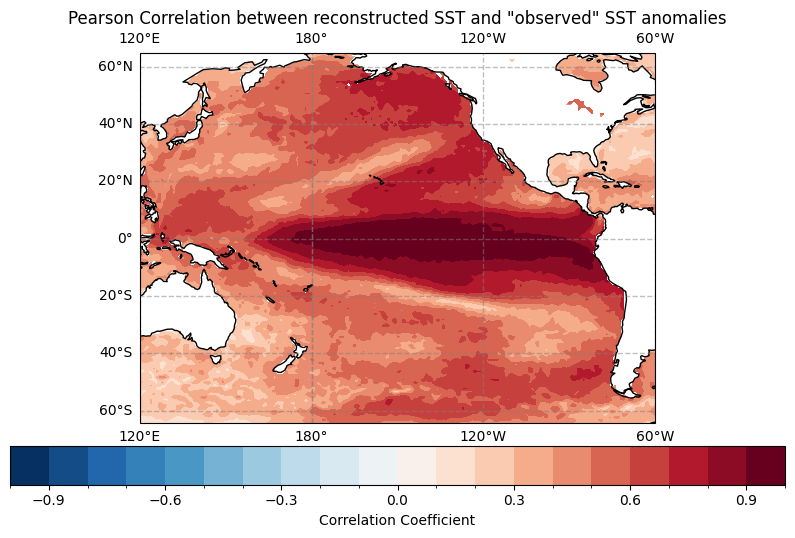

In [32]:
# now to calculate the corr coef for the reconstructed sst and the observed sst
corr_sst = xr.corr(recon_sst, standardized_anomalies, dim='time')

# plot the correlation map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOF
clevs = np.linspace(-1, 1, 21)
fill = corr_sst.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
    
# Calculate variance fraction
ax.set_title('Pearson Correlation between reconstructed SST and "observed" SST anomalies')

# add colorbar
cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Correlation Coefficient', fontsize=10)


This is my attempt without the SST anomalies in case this is what the question was asking for instead

In [33]:
# assuming it does not want us to use the anomaly variables like the previous questions
# I will re-do the EOF with my regular SST dataset
coslat2 = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts2 = np.sqrt(coslat2)[..., np.newaxis]
solver2 = Eof(sst, weights=wgts2)

In [34]:
pc2 = solver2.pcs(npcs=5, pcscaling=1)
reconstruction_sst = solver2.reconstructedField(5)

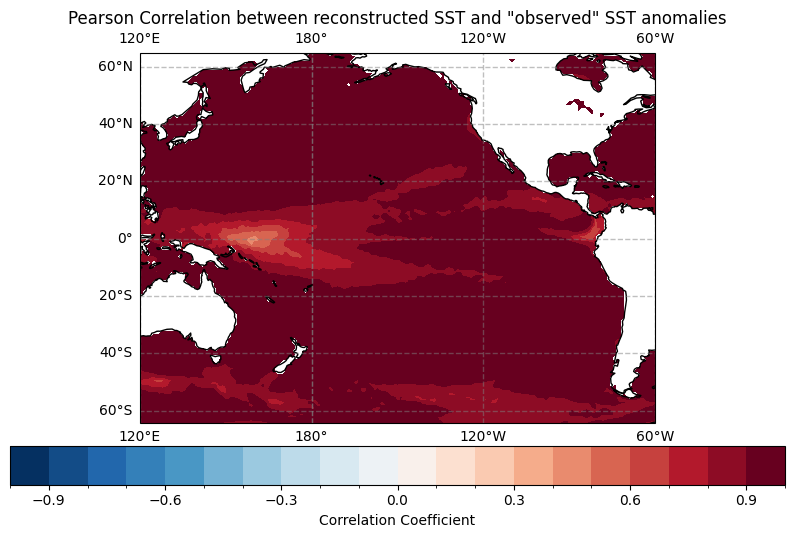

In [35]:
# now to calculate the corr coef for the reconstructed sst and the observed sst
corr_coef_sst = xr.corr(reconstruction_sst, sst, dim='time')

# plot the correlation map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOF
clevs = np.linspace(-1, 1, 21)
fill = corr_coef_sst.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
    
# Calculate variance fraction
ax.set_title('Pearson Correlation between reconstructed SST and "observed" SST anomalies')

# add colorbar
cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Correlation Coefficient', fontsize=10)

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot). See anything interesting?

In [36]:
# so use standardized_anomalies for the sst (eof1?)

tcwv = raw_ds['Total_column_water_vapour_surface_Mixed_intervals_Average']
tcwv

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
[12141480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes: (12/14)
    long_name:                       Total column water vapour (Mixed_interva...
    units:                           kg m**-2
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-137_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 137
    Grib1_Parameter_Name:            tcwv
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [37]:
# Handling infinite values by replacing them with NaN
tcwv_2 = tcwv.where(np.isfinite(tcwv), np.nan)

# Calculating climatology (monthly means) and anomalies, skipping NaN values
climatology2 = tcwv_2.groupby('time.month').mean('time', skipna=True)
anomalies2 = tcwv_2.groupby('time.month') - climatology2

# Detrending the anomalies
def detrend(da2):
    da_no_nan2 = da2.fillna(0)
    detrended2 = xr.apply_ufunc(signal.detrend, da_no_nan2, kwargs={'axis': 0}, dask='allowed')
    return detrended2.where(~da2.isnull())
detrended_anomalies2 = detrend(anomalies2)

detrended_anomalies2 # I think it worked? maybe? I did use a classmates code from the chat that perfectly worked
# with my code, very helpful and informative

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
array([[[-5.2684480e-01, -4.6554685e-01, -3.9721420e-01, ...,
          1.7788599e+00,  1.8392597e+00,  1.9031701e+00],
        [-6.0907018e-01, -5.5912447e-01, -5.0125372e-01, ...,
          1.7628781e+00,  1.8355534e+00,  1.9054265e+00],
        [-6.4761186e-01, -5.9781176e-01, -5.5185151e-01, ...,
          1.7829205e+00,  1.8613626e+00,  1.9330583e+00],
        ...,
        [-1.2027335e+00, -1.2299864e+00, -1.3036207e+00, ...,
          9.0453053e-01,  7.9301810e-01,  6.6572744e-01],
        [-1.3144698e+00, -1.3222134e+00, -1.3085322e+00, ...,
          6.1782944e-01,  5.0341499e-01,  3.7073281e-01],
        [-1.2830224e+00, -1.2885219e+00, -1.2786325e+00, ...,
          6.0778755e-01,  4.2396563e-01,  2.9204985e-01]],

       [[-3.5300553e-01, -3.2700399e-01, -2.9474571e-01, ...,
          1.1450118e+00,  1.3131192e+00,  1.4577836e+00],
        [-3.0973396e-01, -2.9138017e-01, -2.6909298e-01, ...,
          1.2907810e+00,  1.5211983e+00,  1.7788308e+00],
        [-2.1353310e-01, -2.1467590e-01, -2.1783093e-01, ...,
          1.5337527e+00,  1.8547969e+00,  2.1218638e+00],
...
        [-1.0961999e+00, -1.0821757e+00, -1.0568970e+00, ...,
          3.5450068e-01,  3.4735727e-01,  3.4333009e-01],
        [-1.0661248e+00, -1.0629987e+00, -1.0550675e+00, ...,
          5.2299714e-01,  5.2567422e-01,  4.4139099e-01],
        [-1.0156474e+00, -1.0130390e+00, -9.7192991e-01, ...,
          5.6620282e-01,  3.4740430e-01,  1.4035273e-01]],

       [[-7.4580789e-01, -7.4042737e-01, -7.2716051e-01, ...,
          6.4745581e-01,  7.0830834e-01,  8.2840073e-01],
        [-7.4236643e-01, -7.5061476e-01, -7.5241315e-01, ...,
          5.4577285e-01,  6.2837046e-01,  7.3057705e-01],
        [-7.1751940e-01, -7.0300293e-01, -6.9193619e-01, ...,
          4.9170956e-01,  5.8900356e-01,  6.4571339e-01],
        ...,
        [ 7.2398078e-01,  7.6056755e-01,  7.4528897e-01, ...,
          2.8291476e-01,  2.8857252e-01,  2.9306680e-01],
        [ 7.8161931e-01,  6.3756466e-01,  4.5073643e-01, ...,
          2.9483831e-01,  2.6569802e-01,  2.1090314e-01],
        [ 1.6755038e-01, -1.8686429e-03, -1.8522227e-01, ...,
          3.7948385e-01,  2.8116953e-01,  9.5498964e-02]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [38]:
# get STD of dentrended_anomalies2
tcwv_std_ano = detrended_anomalies2.std()

# standardize this variable
tcwv_standardized_anomalies = detrended_anomalies2 / tcwv_std_ano
tcwv_standardized_anomalies


<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
array([[[-1.99057594e-01, -1.75897405e-01, -1.50079310e-01, ...,
          6.72106028e-01,  6.94926858e-01,  7.19074130e-01],
        [-2.30124772e-01, -2.11253807e-01, -1.89388528e-01, ...,
          6.66067600e-01,  6.93526506e-01,  7.19926655e-01],
        [-2.44686961e-01, -2.25871012e-01, -2.08505869e-01, ...,
          6.73640251e-01,  7.03278005e-01,  7.30366707e-01],
        ...,
        [-4.54428375e-01, -4.64725345e-01, -4.92546558e-01, ...,
          3.41758460e-01,  2.99625754e-01,  2.51531571e-01],
        [-4.96645689e-01, -4.99571443e-01, -4.94402289e-01, ...,
          2.33434290e-01,  1.90205112e-01,  1.40073851e-01],
        [-4.84763920e-01, -4.86841768e-01, -4.83105272e-01, ...,
          2.29640156e-01,  1.60186782e-01,  1.10345095e-01]],

       [[-1.33375958e-01, -1.23551801e-01, -1.11363672e-01, ...,
          4.32619393e-01,  4.96135354e-01,  5.50793886e-01],
        [-1.17026672e-01, -1.10092066e-01, -1.01671308e-01, ...,
          4.87695336e-01,  5.74753821e-01,  6.72095001e-01],
        [-8.06791410e-02, -8.11109245e-02, -8.23029801e-02, ...,
          5.79497218e-01,  7.00797260e-01,  8.01703095e-01],
...
          1.33940876e-01,  1.31241873e-01,  1.29720286e-01],
        [-4.02813554e-01, -4.01632428e-01, -3.98635805e-01, ...,
          1.97603822e-01,  1.98615313e-01,  1.66770607e-01],
        [-3.83741707e-01, -3.82756174e-01, -3.67223948e-01, ...,
          2.13928223e-01,  1.31259650e-01,  5.30294217e-02]],

       [[-2.81788349e-01, -2.79755414e-01, -2.74742812e-01, ...,
          2.44628012e-01,  2.67619908e-01,  3.12994361e-01],
        [-2.80488044e-01, -2.83604503e-01, -2.84283996e-01, ...,
          2.06209168e-01,  2.37416998e-01,  2.76033670e-01],
        [-2.71100104e-01, -2.65615344e-01, -2.61434019e-01, ...,
          1.85782447e-01,  2.22543016e-01,  2.43969664e-01],
        ...,
        [ 2.73541421e-01,  2.87364960e-01,  2.81592280e-01, ...,
          1.06893584e-01,  1.09031253e-01,  1.10729329e-01],
        [ 2.95318961e-01,  2.40890831e-01,  1.70301586e-01, ...,
          1.11398660e-01,  1.00388587e-01,  7.96854571e-02],
        [ 6.33055046e-02, -7.06028717e-04, -6.99824691e-02, ...,
          1.43380255e-01,  1.06234185e-01,  3.60823423e-02]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

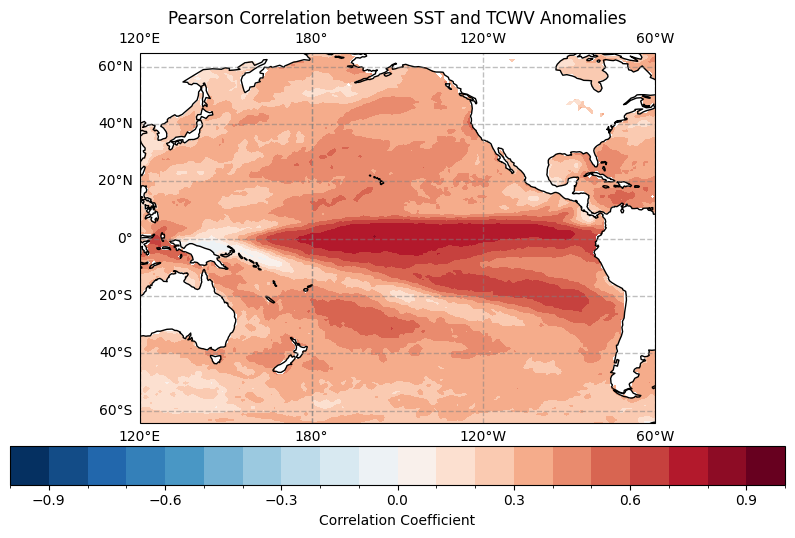

In [39]:
# now to calculate the corr coef for the SST anomalies and TCWV anomalies

corr_sst_tcwv = xr.corr(standardized_anomalies, tcwv_standardized_anomalies, dim='time')

# plot the correlation map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOF
clevs = np.linspace(-1, 1, 21)
fill = corr_sst_tcwv.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
    
# Calculate variance fraction
ax.set_title('Pearson Correlation between SST and TCWV Anomalies')

# add colorbar
cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Correlation Coefficient', fontsize=10)

In [40]:
client.close()